# Base d'apprentissage et de test

Le modèle est estimé sur une base d'apprentissage et évalué sur une base de test.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_datasets
df = load_wines_datasets()
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']

On divise en base d'apprentissage et de test avec la fonction [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

In [5]:
prediction = knn.predict(X_test)

In [6]:
import pandas
res = pandas.DataFrame(dict(expected=y_test, prediction=prediction))
res.head()

,expected,prediction
4406,5,6.0
2773,6,5.0
5699,6,7.0
1520,6,6.0
856,6,6.0


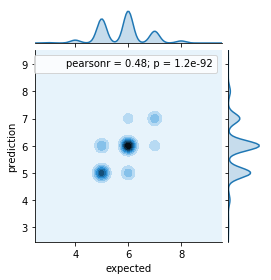

In [7]:
from seaborn import jointplot
jointplot("expected", "prediction", res, kind="kde", size=4)

Le résultat paraît acceptable. On enlève les réponses correctes.

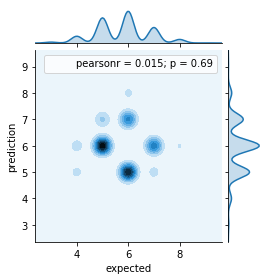

In [8]:
jointplot("expected", "prediction", res[res['expected'] != res['prediction']], kind="kde", size=4)

In [9]:
res['diff'] = res['prediction'] - res["expected"]

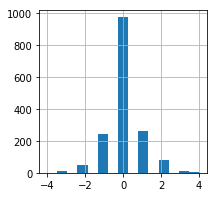

In [10]:
res['diff'].hist(bins=15, figsize=(3,3))

Si on fait la moyenne des erreurs en valeur absolue :

In [11]:
import numpy
numpy.abs(res['diff']).mean()

0.5163076923076924

Le modèle se trompe en moyenne d'un demi point. Le module *scikit-learn* propose de nombreuses [métriques](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) pour évaluer les résultats. On s'intéresse plus particulièrement à celle de la [régression](http://scikit-learn.org/stable/modules/classes.html#regression-metrics). Celle qu'on a utilisée s'appelle [mean_absolute_error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error).

In [12]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, prediction)

0.5163076923076924

Un autre indicateur très utilisé : [R2](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score).

In [13]:
from sklearn.metrics import r2_score
r2_score(y_test, prediction)

-0.02191006650559002

Une valeur négative implique que le modèle fait moins bien que si la prédiction était constante et égale à la moyenne des notes sur la base de test. Essayons.

In [14]:
const = numpy.mean(y_test) * numpy.ones(y_test.shape[0])
r2_score(y_test, const)

0.0

Pour être rigoureux, il faudrait prendre la moyenne des notes sur la base d'apprentissage, celles des vins connus.

In [15]:
const = numpy.mean(y_train) * numpy.ones(y_test.shape[0])
r2_score(y_test, const)

-0.0011246364234323014

Sensiblement pareil et on sait maintenant que le modèle n'est pas bon. On cherche une explication. Une raison possible est que les bases d'apprentissage et de test ne sont pas homogènes : le modèle apprend sur des données et est testé sur d'autres qui n'ont rien à voir. On commence par regarder la distribution des notes.

In [16]:
ys = pandas.DataFrame(dict(y=y_train))
ys['base'] = 'train'
ys2 = pandas.DataFrame(dict(y=y_test))
ys2['base'] = 'test'
ys = pandas.concat([ys, ys2])
ys['compte'] = 1
piv = ys.groupby(['base', 'y'], as_index=False).count().pivot('y', 'base', 'compte')
piv['ratio'] = piv['test'] / piv['train']
piv

base,test,train,ratio
y,,,
3,8,22,0.363636
4,64,152,0.421053
5,536,1602,0.334582
6,708,2128,0.332707
7,262,817,0.320685
8,46,147,0.312925
9,1,4,0.250000


On voit le ratio entre les deux classes est à peu près égal à 1/3 sauf pour les notes sous-représentées. On voit également que les classes 5,6,7 sont sur-représentées. Autrement dit, si je choisis un vin au hasard, il y a 90% de chance que sa note soit 5, 6 ou 7.